# Parsing author data from csv

You will need the following in your LaTeX header for the hyperlinks and ORCiD symbols to work:
```
\usepackage{graphicx}	% Including figure files
\usepackage{amsmath}	% Advanced maths commands
\usepackage{scalerel}
\usepackage{tikz}
\usetikzlibrary{svg.path}

\definecolor{orcidlogocol}{HTML}{A6CE39}
\tikzset{
  orcidlogo/.pic={
    \fill[orcidlogocol] svg{M256,128c0,70.7-57.3,128-128,128C57.3,256,0,198.7,0,128C0,57.3,57.3,0,128,0C198.7,0,256,57.3,256,128z};
    \fill[white] svg{M86.3,186.2H70.9V79.1h15.4v48.4V186.2z}
                 svg{M108.9,79.1h41.6c39.6,0,57,28.3,57,53.6c0,27.5-21.5,53.6-56.8,53.6h-41.8V79.1z M124.3,172.4h24.5c34.9,0,42.9-26.5,42.9-39.7c0-21.5-13.7-39.7-43.7-39.7h-23.7V172.4z}
                 svg{M88.7,56.8c0,5.5-4.5,10.1-10.1,10.1c-5.6,0-10.1-4.6-10.1-10.1c0-5.6,4.5-10.1,10.1-10.1C84.2,46.7,88.7,51.3,88.7,56.8z};
  }
}

\newcommand\orcidicon[1]{\href{https://orcid.org/#1}{\mbox{\scalerel*{
\begin{tikzpicture}[xscale=0.1,yscale=-0.1,transform shape]
\pic{orcidlogo};
\end{tikzpicture}
}{|}}}}

\usepackage{hyperref}   %Needs to be at the end for some reason
```


In [2]:
import pandas as pd
import numpy as np

In [17]:
full_list=pd.read_csv("https://raw.githubusercontent.com/adleleu/author_list/main/CHEOPS_Science_Team.csv")
full_list=full_list.loc[full_list['Ref name']!='Mathias Beck']

In [3]:
journal='a&a'
if journal=='a&a':
    authsep="\\and"
else:
    authsep=","
    
do_link=False

orcbefore=False

approved=True

In [4]:
df=pd.read_csv("TOI-2076 author list.tsv",delimiter='\t',comment='#')

In [5]:
df['surname']=[' '.join(v.split(' ')[1:]) if len(v.split(' ')[1])>2 else ' '.join(v.split(' ')[2:]) for v in df.NAME.values]

In [6]:
lead_author = df.loc[df.index.values==0]
second_authors = df.loc[df["Rank position"]=="MC"].sort_values('surname')
third_authors = df.loc[df["Rank position"]=="SE"].sort_values('surname')
fourth_authors = df.loc[df["Rank position"]=="SC"].sort_values('surname')
other_authors = df.loc[(df["Rank position"]!="SC")&(df["Rank position"]!="SE")&(df["Rank position"]!="MC")&(df.index>0)].sort_values('surname')

In [6]:
all_affils=[]
df['N_AFFILS']=np.tile(-99,len(df))
start_latex="\\author{"

auth=lead_author.iloc[0]
n=0
#First author info:        
if (not do_link) or journal!='a&a':
    if auth['AFFILIATION 1 (Latex-compatible)'] in all_affils:
        naffil=str(all_affils.index(auth['AFFILIATION 1 (Latex-compatible)'])+1)
        df.loc[n,'N_AFFILS']="\\inst{"+naffil+"}"
    else:
        naffil=str(len(all_affils)+1)
        df.loc[n,'N_AFFILS']="\\inst{"+naffil+"}"
        all_affils+=[auth['AFFILIATION 1 (Latex-compatible)']]
    if not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']) and auth['AFFILIATION 2 (Latex-compatible)'] in all_affils:
        naffil=str(all_affils.index(auth['AFFILIATION 2 (Latex-compatible)'])+1)
        df.loc[n,'N_AFFILS']+="\\fnmsep"+"\\inst{"+naffil+"}"
    elif not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']):
        naffil=str(len(all_affils)+1)
        df.loc[n,'N_AFFILS']+="\\fnmsep"+"\\inst{"+naffil+"}"
        all_affils+=[auth['AFFILIATION 2 (Latex-compatible)']]

else:
    if auth['AFFILIATION 1 (Latex-compatible)'] in all_affils:
        naffil=str(all_affils.index(auth['AFFILIATION 1 (Latex-compatible)'])+1)
        df.loc[n,'N_AFFILS']="\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
    else:
        naffil=str(len(all_affils)+1)
        df.loc[n,'N_AFFILS']="\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
        all_affils+=[auth['AFFILIATION 1 (Latex-compatible)']]
    if not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']) and auth['AFFILIATION 2 (Latex-compatible)'] in all_affils:
        naffil=str(all_affils.index(auth['AFFILIATION 2 (Latex-compatible)'])+1)
        df.loc[n,'N_AFFILS']+=","+"\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
    elif not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']):
        naffil=str(len(all_affils)+1)
        df.loc[n,'N_AFFILS']+=","+"\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
        all_affils+=[auth['AFFILIATION 2 (Latex-compatible)']]

#Making first name into initial:
if '.' not in auth['NAME'].split(' ')[0]:
    abrv_firstname=auth['NAME'].split(' ')[0][0]+'. ' if '-' not in auth['NAME'].split(' ')[0] else auth['NAME'].split(' ')[0].split('-')[0][0]+'.-'+auth['NAME'].split(' ')[0].split('-')[1][0]+'. '
    name=abrv_firstname+'~'.join(auth['NAME'].split(' ')[1:])
else:
    name=auth['NAME']
if len(name.split('. '))>2:
    name='.'.join(name.split('. ')[:-1])+'. '+name.split('. ')[-1]
name=name.replace(' ','~')

#adding ORCiD:
if not pd.isnull(auth['ORCiD']):
    if not do_link or journal!='a&a':
        orc="\\textsuperscript{\\orcidicon{"+str(auth['ORCiD'])+"},}" if orcbefore else "\\textsuperscript{,\\orcidicon{"+str(auth['ORCiD'])+"}}"
    else:
        orc="\\orcidicon{"+str(auth['ORCiD'])+",}" if orcbefore else "\\orcidicon{,"+str(auth['ORCiD'])+"}"
else:
    orc=""
    
thanks="\\thanks{E-mail:"+auth["EMAIL (optional)"]+"} "

#adding author info to latex:
if not do_link or journal!='a&a':
    start_latex+=name+orc+df.loc[n,'N_AFFILS']+thanks+authsep+' %' if orcbefore else name+df.loc[n,'N_AFFILS']+orc+thanks+authsep+' %'

else:
    start_latex+=name+'\\textsuperscript{'+orc+df.loc[n,'N_AFFILS']+'}'+thanks+authsep+' %' if orcbefore else name+'\\textsuperscript{'+df.loc[n,'N_AFFILS']+orc+'}'+thanks+authsep+' %'
if not pd.isnull(auth["EMAIL (optional)"]):
    start_latex+=' '+auth["EMAIL (optional)"]
if not pd.isnull(auth["CONTRIBUTION"]):
    start_latex+=' '+auth["CONTRIBUTION"]
start_latex+='\n'


if not approved:
    start_latex+="\\textbf{Author list TBD \\& pending Cheops GTO approval} \\and\n"
    
all_names=name+', '

In [7]:
print(start_latex)

\author{H.P.~Osborn\inst{1}\fnmsep\inst{2}\textsuperscript{,\orcidicon{0000-0002-4047-4724}}\thanks{E-mail:hugh.osborn@space.unibe.ch} \and % hugh.osborn@space.unibe.ch First author



In [8]:
for idf in [second_authors,third_authors,fourth_authors,other_authors]:
    for n,auth in idf.iterrows():
        #Creating affiliations:
        if not do_link or journal!='a&a':
            if auth['AFFILIATION 1 (Latex-compatible)'] in all_affils:
                naffil=str(all_affils.index(auth['AFFILIATION 1 (Latex-compatible)'])+1)
                df.loc[n,'N_AFFILS']="\\inst{"+naffil+"}"
            else:
                naffil=str(len(all_affils)+1)
                df.loc[n,'N_AFFILS']="\\inst{"+naffil+"}"
                all_affils+=[auth['AFFILIATION 1 (Latex-compatible)']]
            if not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']) and auth['AFFILIATION 2 (Latex-compatible)'] in all_affils:
                naffil=str(all_affils.index(auth['AFFILIATION 2 (Latex-compatible)'])+1)
                df.loc[n,'N_AFFILS']+="\\fnmsep"+"\\inst{"+naffil+"}"
            elif not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']):
                naffil=str(len(all_affils)+1)
                df.loc[n,'N_AFFILS']+="\\fnmsep"+"\\inst{"+naffil+"}"
                all_affils+=[auth['AFFILIATION 2 (Latex-compatible)']]

        else:
            if auth['AFFILIATION 1 (Latex-compatible)'] in all_affils:
                naffil=str(all_affils.index(auth['AFFILIATION 1 (Latex-compatible)'])+1)
                df.loc[n,'N_AFFILS']="\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
            else:
                naffil=str(len(all_affils)+1)
                df.loc[n,'N_AFFILS']="\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
                all_affils+=[auth['AFFILIATION 1 (Latex-compatible)']]
            if not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']) and auth['AFFILIATION 2 (Latex-compatible)'] in all_affils:
                naffil=str(all_affils.index(auth['AFFILIATION 2 (Latex-compatible)'])+1)
                df.loc[n,'N_AFFILS']+=","+"\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
            elif not pd.isnull(auth['AFFILIATION 2 (Latex-compatible)']):
                naffil=str(len(all_affils)+1)
                df.loc[n,'N_AFFILS']+=","+"\\hyperlink{affil_"+naffil+"}{"+naffil+"}"
                all_affils+=[auth['AFFILIATION 2 (Latex-compatible)']]

        #Making first name into initial:
        if '.' not in auth['NAME'].split(' ')[0]:
            abrv_firstname=auth['NAME'].split(' ')[0][0]+'. ' if '-' not in auth['NAME'].split(' ')[0] else auth['NAME'].split(' ')[0].split('-')[0][0]+'.-'+auth['NAME'].split(' ')[0].split('-')[1][0]+'. '
            name=abrv_firstname+'~'.join(auth['NAME'].split(' ')[1:])
        else:
            name=auth['NAME']
        if len(name.split('. '))>2:
            name='.'.join(name.split('. ')[:-1])+'. '+name.split('. ')[-1]
        name=name.replace(' ','~')
        

        #adding ORCiD:
        if not pd.isnull(auth['ORCiD']):
            if not do_link or journal!='a&a':
                orc="\\orcidicon{"+str(auth['ORCiD'])+"}" if orcbefore else "\\orcidicon{"+str(auth['ORCiD'])+"}"
            else:
                orc="\\orcidicon{"+str(auth['ORCiD'])+"}" if orcbefore else "\\orcidicon{"+str(auth['ORCiD'])+"}"
        else:
            orc=""

        #adding author info to latex:
        if not do_link or journal!='a&a':
            start_latex+=name+orc+df.loc[n,'N_AFFILS']+' '+authsep+' %' if orcbefore else name+df.loc[n,'N_AFFILS']+orc+' '+authsep+' %'

        else:
            start_latex+=name+orc+df.loc[n,'N_AFFILS']+'} '+authsep+' %' if orcbefore else name+'{'+df.loc[n,'N_AFFILS']+orc+' '+authsep+' %'
        if not pd.isnull(auth["EMAIL (optional)"]):
            start_latex+=' '+auth["EMAIL (optional)"]
        if not pd.isnull(auth["CONTRIBUTION"]):
            start_latex+=' '+auth["CONTRIBUTION"]
        start_latex+='\n'
        
        all_names+=name+', '


In [9]:
all_names.replace('~','')

'H.P.Osborn, A.Bonfanti, D.Gandolfi, C.Hedges, A.Leleu, A.Fortier, D.Futyan, P.Gutermann, P.F.L.Maxted, L.Borsato, K.A.Collins, J.GomesdaSilva, Y.GómezMaqueoChew, M.J.Hooton, M.Lendl, H.Parviainen, S.Salmon, N.Schanche, L.M.Serrano, S.G.Sousa, A.Tuson, S.Ulmer-Moll, V.VanGrootel, R.D.Wells, T.G.Wilson, Y.Alibert, R.Alonso, G.Anglada, J.Asquier, D.BarradoyNavascues, W.Baumjohann, T.Beck, W.Benz, F.Biondi, X.Bonfils, F.Bouchy, A.Brandeker, C.Broeg, T.Bárczy, S.C.C.Barros, J.Cabrera, S.Charnoz, A.CollierCameron, S.Csizmadia, M.B.Davies, M.Deleuil, L.Delrez, B.-O.Demory, D.Ehrenreich, A.Erikson, L.Fossati, M.Fridlund, M.Gillon, M.A.Gómez-Muñoz, M.Güdel, K.Heng, S.Hoyer, K.G.Isaak, L.Kiss, J.Laskar, A.LecavelierdesEtangs, C.Lovis, D.Magrin, L.Malavolta, J.McCormac, V.Nascimbeni, G.Olofsson, R.Ottensamer, I.Pagano, E.Pallé, G.Peter, D.Piazza, G.Piotto, D.Pollacco, D.Queloz, R.Ragazzoni, N.Rando, H.Rauer, C.Reimers, I.Ribas, O.D.S.Demangeon, A.M.S.Smith, L.Sabin, N.Santos, G.Scandariato, U.Sc

In [10]:
#Removing the last "and"
print(start_latex[-50:])
start_latex=start_latex[:-50]+start_latex[-50:].replace("\\and","")
print(start_latex[-50:])

inst{59} \and % naw@ast.cam.ac.uk Cheops GTO team

ton\inst{59}  % naw@ast.cam.ac.uk Cheops GTO team



In [11]:
start_latex

'\\author{H.P.~Osborn\\inst{1}\\fnmsep\\inst{2}\\textsuperscript{,\\orcidicon{0000-0002-4047-4724}}\\thanks{E-mail:hugh.osborn@space.unibe.ch} \\and % hugh.osborn@space.unibe.ch First author\nA.~Bonfanti\\inst{3}\\orcidicon{0000-0002-1916-5935} \\and % andrea.bonfanti@oeaw.ac.at Stellar parameters\nD.~Gandolfi\\inst{4}\\orcidicon{0000-0001-8627-9628} \\and % davide.gandolfi@unito.it Advisor to Cheops duotransits team & Explore Program manager\nC.~Hedges\\inst{5}\\fnmsep\\inst{6}\\orcidicon{0000-0002-3385-8391} \\and % christina.l.hedges@nasa.gov TESS lightcurve, knowledge of duotransits system\nA.~Leleu\\inst{7}\\orcidicon{0000-0003-2051-7974} \\and % Adrien.Leleu@unige.ch MMR analysis\nA.~Fortier\\inst{1}\\fnmsep\\inst{8}\\orcidicon{0000-0001-8450-3374} \\and % andrea.fortier@unibe.ch Cheops GTO team; Cheops Science Enabler nom. by DQ\nD.~Futyan\\inst{7} \\and % David.Futyan@unige.ch Cheops Science Enabler nom. by DQ\nP.~Gutermann\\inst{9}\\fnmsep\\inst{10} \\and % pascal.guterman@lam

In [12]:
if journal!='a&a':
    start_latex+="}\\\\\n\\vspace{0.4cm}\n\\parbox{\\textwidth}{\nThe authors' affiliations are shown in Appendix \\ref{sec:affiliations}.}\n}"
elif do_link:
    start_latex+="}\n\institute{The authors' affiliations are shown in Appendix \\ref{sec:affiliations}.\n}"
else:
    start_latex+="}\n"
    

In [13]:
aff_box=""
if not do_link and journal=='a&a':
    aff_box+="\\institute{"
for n,row in enumerate(all_affils):
    if do_link:
        aff_box+="\\textsuperscript{\\hypertarget{affil_"+str(n+1)+"}{"+str(n+1)+"}} "
    aff_box+=row
    if journal=='a&a':
        aff_box+=" \\and"
    elif row[-2]!='\\':
        aff_box+="\\\\"
    aff_box+="\n"
if not do_link and journal=='a&a':
    aff_box+="}"

#Removing the last "and"
print(aff_box[-25:])
aff_box=aff_box[:-25]+aff_box[-25:].replace("\\and","")
print(aff_box[-25:])

HA, United Kingdom \and
}
B3 0HA, United Kingdom 
}


In [14]:
with open("authorlist.tex","w") as file:
    file.writelines(start_latex+'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%.    WARNING:  DO NOT EDIT YOUR AUTHOR INFO HERE.    %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
% Author info is auto-generated from this google spreadsheet: https://docs.google.com/spreadsheets/d/17KRQMYalFKKTm0ZJO5wHxUhVfgf1chrhw8q7WHVYig0/edit?usp=sharing 
%
'''+aff_box)

In [15]:
acks=[]
for n,row in df.iterrows():
    if type(row['ACKNOWLEDGEMENT (Latex-compatible)'])==str:
        ack=row['ACKNOWLEDGEMENT (Latex-compatible)']
        #ack=ack.split('\\')[0] if '\\' in ack else ack 
        acks+=[ack+"\\\\ %"+row['NAME']]
with open("acknowledgements.tex","w") as file:
    file.writelines('\n'.join(acks))

In [16]:
print('\n'.join(acks))

This work makes use of observations from the LCOGT network. Part of the LCOGT telescope time was granted by NOIRLab through the Mid-Scale Innovations Program (MSIP). MSIP is funded by NSF.\\ %K. A. Collins
AT acknowledges support from an STFC PhD studentship.\\ %A. Tuson
This work has been carried out within the framework of the NCCR PlanetS supported by the Swiss National Science Foundation.\\ %S. Ulmer-Moll
DG and LMS gratefully acknowledge financial support from the \emph{Cassa di Risparmio di Torino} (CRT) foundation under Grant No. 2018.2323 ``Gaseousor rocky? Unveiling the nature of small worlds''.\\ %D. Gandolfi
S.G.S acknowledges the support from FCT through Investigador FCT contract nr. CEECIND/00826/2018 and  POPH/FSE (EC). This  work  was  supported  by FCT - Fundac\c{c}\~ao  para  a  Ci\^encia  e  Tecnologia through national  funds and by FEDER through COMPETE2020 - Programa Operacional Competitividade e Internacionaliza\c{c}\~ao by these grants:PTDC/FIS-AST/32113/2017 \& P

In [8]:
latex_names=[]
for idf in [lead_author,second_authors,third_authors,fourth_authors,other_authors]:
    for n,auth in idf.iterrows():
        latex_names+=[auth['NAME']]
print(', '.join(latex_names))

Hugh P. Osborn, Andrea Bonfanti, Davide Gandolfi, Christina Hedges, Adrien Leleu, Andrea Fortier, David Futyan, Pascal Gutermann, Pierre F. L. Maxted, Luca Borsato, Karen A. Collins, J. Gomes~da~Silva, Yilen Gómez~Maqueo~Chew, Matthew J. Hooton, Monika Lendl, Hannu Parviainen, Sébastien Salmon, Nicole Schanche, Luisa M. Serrano, Sergio G. Sousa, Amy Tuson, Solène Ulmer-Moll, Valerie Van Grootel, R.D. Wells, Thomas G. Wilson, Yann Alibert, Roi Alonso, Guillem Anglada, Joel Asquier, David Barrado y Navascues, Wolfgang Baumjohann, Thomas Beck, Willy Benz, Federico Biondi, Xavier Bonfils, Francois Bouchy, Alexis Brandeker, Christopher Broeg, Tamas Bárczy, S. C. C. Barros, Juan Cabrera, Sébastien Charnoz, Andrew Collier Cameron, Szilard Csizmadia, Melvyn B. Davies, Magali Deleuil, Laetitia Delrez, Brice-Olivier Demory, David Ehrenreich, Anders Erikson, Luca Fossati, Malcolm Fridlund, Michaël Gillon, M.A. Gómez-Muñoz, Manuel Güdel, Kevin Heng, Sergio Hoyer, Kate G. Isaak, Laszlo Kiss, Jacque

2.8545454545454545 0.7958570410268831


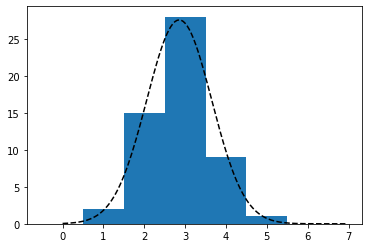

In [21]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

dat=np.array([0,2,15,28,9,1])
samps=np.hstack([np.tile(t,dat[t]) for t in range(6)])

# best fit of data
(mu, sigma) = norm.fit(samps)

# the histogram of the data
plt.bar(np.arange(0,6,1), dat,width=1.0)
plt.plot(np.arange(0,7,0.05),np.sum(dat)*norm(mu,sigma).pdf(np.arange(0,7,0.05)),'--k')
print(1+mu,sigma)
print(100*(1.0-norm(mu,sigma).cdf(5.51)))

4.413793103448276 1.0991294793454638
15.929950893742184


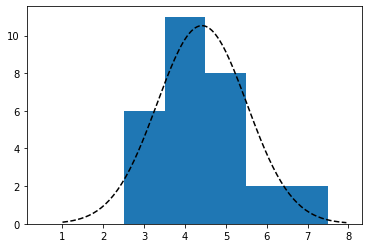

In [39]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

dat=np.array([0,0,6,11,8,2,2])
samps=np.hstack([np.tile(t+1,dat[t]) for t in np.arange(1,7)])

# best fit of data
(mu, sigma) = norm.fit(samps)

# the histogram of the data
plt.bar(np.arange(1,7.1,1), dat,width=1.0)
plt.plot(np.arange(1,8,0.05),np.sum(dat)*norm(mu,sigma).pdf(np.arange(1,8,0.05)),'--k')
print(mu,sigma)
print(100*(1.0-norm(mu,sigma).cdf(5.51)))

In [38]:
samps

array([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 6, 6])

In [12]:
plt.bar?
#(np.arange(0,6.1,1), dat)

In [19]:
norm(mu,sigma).pdf(np.arange(0,7,0.05))

array([8.06332717e-04, 1.00813986e-03, 1.25548961e-03, 1.55736815e-03,
       1.92422246e-03, 2.36812762e-03, 2.90295800e-03, 3.54455918e-03,
       4.31091580e-03, 5.22231035e-03, 6.30146666e-03, 7.57367104e-03,
       9.06686315e-03, 1.08116882e-02, 1.28415011e-02, 1.51923132e-02,
       1.79026715e-02, 2.10134620e-02, 2.45676268e-02, 2.86097874e-02,
       3.31857689e-02, 3.83420180e-02, 4.41249147e-02, 5.05799760e-02,
       5.77509573e-02, 6.56788569e-02, 7.44008354e-02, 8.39490657e-02,
       9.43495322e-02, 1.05620803e-01, 1.17772802e-01, 1.30805612e-01,
       1.44708345e-01, 1.59458107e-01, 1.75019106e-01, 1.91341928e-01,
       2.08363029e-01, 2.26004457e-01, 2.44173865e-01, 2.62764795e-01,
       2.81657297e-01, 3.00718860e-01, 3.19805666e-01, 3.38764170e-01,
       3.57432974e-01, 3.75644979e-01, 3.93229771e-01, 4.10016205e-01,
       4.25835126e-01, 4.40522171e-01, 4.53920596e-01, 4.65884043e-01,
       4.76279195e-01, 4.84988248e-01, 4.91911129e-01, 4.96967410e-01,
      